In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy import units as u
from astropy.io import fits
from astropy.nddata import CCDData

from astropy.modeling.models import Gaussian1D, Linear1D
from astropy.modeling.fitting import LevMarLSQFitter, LinearLSQFitter

from astropy.table import Table, join

from scipy.signal import find_peaks
from scipy.optimize import fsolve

In [2]:
def get_wave_cal_from_df(df, deg, val, deriv=False):

    # Get poly function
    poly = np.polynomial.polynomial.polyfit(df['gaussian peaks'], df['lambda'], deg)

    # Get new values
    poly_val = np.polynomial.polynomial.polyval(val, poly)

    # If deriv is needed, return deriv
    if deriv:
        poly_deriv = np.polynomial.polynomial.polyder(poly)
        return poly_val, poly_deriv
    
    # Otherwise just values
    else:
        return poly_val

In [3]:
# Crossmatching function within a specified range
def crossmatch(lines_peaks, nist_files, range_max=0.1):
    # Create a new dataframe for the result

    results = []
    # note = []
    # dups = []

    for idx, row1 in lines_peaks.iterrows():

        lam_me = row1['lambda']
        # ion_me = row1['ion']
        
        # Find matches in df2 where y is within the range
        matched_rows = nist_files[(nist_files['vacuum_lambda'] >= lam_me - range_max) & 
                                  (nist_files['vacuum_lambda'] <= lam_me + range_max)]

        if not matched_rows.empty:
            # Append the first matched row to the results
            # note.append('Match found')
            
            for _, row2 in matched_rows.iterrows():
                combined_row = pd.concat([row1, row2])

                # Remove duplicate indices (column names), keeping the first occurrence
                combined_row = combined_row[~combined_row.index.duplicated(keep='first')]
                
                # print(combined_row)
                # print('----')
                results.append(combined_row)
            
    #         if len(matched_rows) > 1:

    #             dups.append('More found')

    #         else:
    #             dups.append('One found')

    #     else:
    #         note.append('No match found')
    #         dups.append('No match found')
    
    # lines_peaks['note'] = note
    # lines_peaks['duplicates?'] = dups

    # Combine results into a new dataframe
    return pd.DataFrame(results)

In [4]:
# Main dictionary for all files
lines = {'Cd': [],
        'Cs': [],
        'He': [],
        'Hg': [],
        # 'HgCd': [],
        # 'HgCd-LLG300': [],
        'Zn': [],
        'HgAr': [],
        'Xe': []
        #  'FP': []
        }

In [5]:
for key, l in lines.items():

    filter = ['blue', 'green']

    # Call master line lists from NIST:
    NIST_list = pd.read_csv('line_lists/NIST/{}_lines.txt'.format(key))

    if 'unc_obs_wl' not in NIST_list.columns:
        NIST_list['unc_obs_wl'] = np.nan
    
    if 'unc_ritz_wl' not in NIST_list.columns:
        NIST_list['unc_ritz_wl'] = np.nan

    # Rename header to something easier
    NIST_list = NIST_list.rename(columns={'sp_num': 'ion',
                                        'obs_wl_air(A)':'vacuum_lambda',
                                        'ritz_wl_air(A)': 'ritz_lambda',
                                        'unc_obs_wl': 'vacuum_sigma',
                                        'unc_ritz_wl': 'ritz_sigma',
                                        'intens': 'intens_NIST'})
    
    # Drop a few columns
    NIST_list = NIST_list.drop(columns=['Aki(s^-1)', 'Acc', 'Type'])
    NIST_list = NIST_list[['vacuum_lambda', 'element', 'ion', 'intens_NIST',
                            'ritz_lambda', 'vacuum_sigma', 'ritz_sigma', 'obs-ritz']]

    for_filters = []
    
    for n in range(2):
    
        # Call master peaks
        master_peaks = pd.read_csv('line_lists/all_gaus/master_peaks_{}_{}.csv'.format(key, filter[n]))

        # Rename headings to make it better
        master_peaks = master_peaks.rename(columns={'sp_num': 'ion',
                                                    'lambda': 'poly_lambda',
                                                    'obs_wl_air(A)': 'vacuum_lambda',
                                                    'amplitudes': 'intens_4MOST'})

        # Get peaks difference of scipy peaks and gaussian peaks
        master_peaks['delta_peaks'] = abs(master_peaks['peaks'] - master_peaks['gaussian peaks'])

        # Filter values in master_peaks
        
        
        if (key == 'HgAr') and (n == 0):
            master_peaks = master_peaks[(master_peaks['intens_4MOST'] <= 1000000) & 
                                        (master_peaks['intens_4MOST'] >= 70) &
                                        (master_peaks['delta_peaks'] <= 5)].reset_index(drop=True).copy()
        else:
            master_peaks = master_peaks[(master_peaks['intens_4MOST'] <= 1000000) & 
                                        (master_peaks['intens_4MOST'] >= 10) &
                                        (master_peaks['delta_peaks'] <= 5)].reset_index(drop=True).copy()

        
        # Transfer lambdas
        for index, row in master_peaks.iterrows():

            if pd.isna(row['vacuum_lambda']):
                master_peaks.at[index, 'lambda'] = row['poly_lambda']
                master_peaks.at[index, 'note'] = '4MOST'
            else:
                master_peaks.at[index, 'lambda'] = row['vacuum_lambda']
        
        # 4MOST & NIST
        # --------------------------------
        # Crossmatch with NIST
        matched_master = crossmatch(master_peaks, NIST_list)

        # Get rid of the pixel peaks
        matched_master = matched_master[['peaks', 'gaussian peaks', 'lambda', 'element', 'ion', 'note', 'intens_4MOST','intens_NIST',
                                            'ritz_lambda', 'vacuum_sigma', 'ritz_sigma', 'obs-ritz']]
        
        # Write notes for positive matches
        matched_master['note'] = ['4MOST & NIST']*len(matched_master)

        # Just 4MOST
        # --------------------------------
        gaus_peaks_no_match = master_peaks[master_peaks['note'] == '4MOST'].copy().reset_index(drop=True)
        gaus_peaks_no_match['element'] = [key]*len(gaus_peaks_no_match)

        # Get rid of the pixels
        gaus_peaks_no_match = gaus_peaks_no_match[['peaks', 'gaussian peaks', 'lambda', 'element', 'note', 'intens_4MOST']]

        # Combine the two dataframe
        combined = pd.concat([matched_master, gaus_peaks_no_match])
        combined = combined.sort_values(by=['gaussian peaks']).reset_index(drop=True)
        # combined.to_csv('line_lists/all_gaus/v2_master_peaks_{}_{}.csv'.format(key, filter[n]), index=False)

        combined = combined.drop(columns=['peaks', 'gaussian peaks'])
        for_filters.append(combined)

        # print(gaus_peaks_no_match)
        # print('----')
        # print(matched_master)
        # print('----')
        # print(combined)
        # print('----')
    
    # Combine dataframe from two arms
    blue_and_green = pd.concat(for_filters, ignore_index=True)

    # Just NIST
    # --------------------------------
    NIST_list = NIST_list.rename(columns={'vacuum_lambda': 'lambda'})
    no_match_nist = NIST_list[~NIST_list['lambda'].isin(blue_and_green['lambda'])].reset_index(drop=True).copy()
    no_match_nist['note'] = ['NIST']*len(no_match_nist)

    # Combine everything into one list
    master_list = pd.concat([blue_and_green, no_match_nist]).sort_values(by=['lambda']).reset_index(drop=True)

    # Export
    # master_list.to_csv('line_lists/compiled/v2_master_list_{}.csv'.format(key), index=False)

In [7]:
# Get all of the lines in the dictonary

blue_df = []
green_df = []
filter = ['blue', 'green']


for key, l in lines.items():

    for n in range(2):

        lines_df = pd.read_csv('line_lists/all_gaus/v2_master_peaks_{}_{}.csv'.format(key, filter[n]))

        # Transfer to new pandas
        lines_cat = lines_df[lines_df['note'] == '4MOST & NIST']
        lines_cat = lines_cat[['gaussian peaks', 'lambda', 'element']].copy()

        if n == 0:
            blue_df.append(lines_cat)
        else:
            green_df.append(lines_cat)
            
blue = pd.concat(blue_df)
green = pd.concat(green_df)

blue = blue.reset_index(drop=True).sort_values(by='gaussian peaks', ignore_index=True).drop_duplicates(subset=['gaussian peaks'])
green = green.reset_index(drop=True).sort_values(by='gaussian peaks', ignore_index=True).drop_duplicates(subset=['gaussian peaks'])

In [8]:
blue

,gaussian peaks,lambda,element
0,347.628906,3790.0000,Hg
1,443.273102,3819.6074,He
2,445.310913,3820.4000,Hg
3,505.477142,3839.2590,Hg
4,574.857605,3860.8500,Hg
...,...,...,...
85,5466.426270,5349.1315,Cs
86,5517.821777,5365.5000,Hg
87,5685.362793,5413.6145,Cs
88,5850.922363,5460.7500,Hg


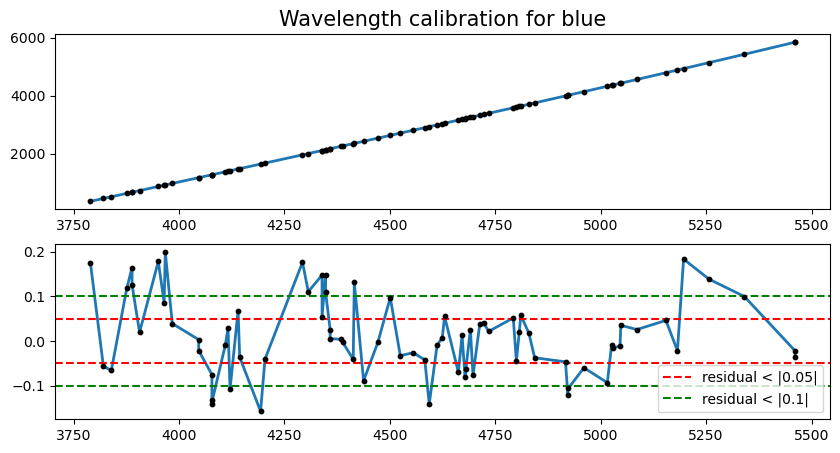

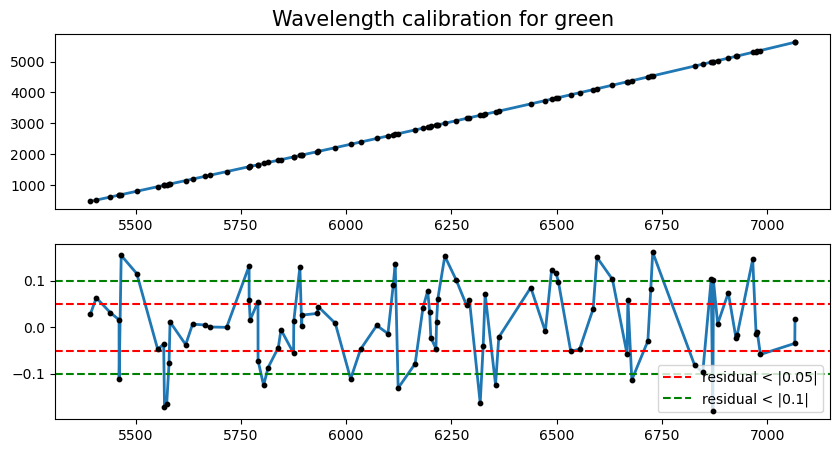

In [9]:
df = [blue, green]
filter = ['blue', 'green']

for n in range(2):

    df_filter = df[n]
    df_filter['poly lambda'] = get_wave_cal_from_df(df_filter, 6, df_filter['gaussian peaks'].values)
    df_filter['residual'] = df_filter['lambda'] - df_filter['poly lambda']

    df_filter = df_filter[(df_filter['residual'] > -0.2) & (df_filter['residual'] < 0.2)]

    # print(len(df_filter))

    f, (ax1, ax2) = plt.subplots(2, 1, figsize=[10,5])

    ax1.set_title('Wavelength calibration for {}'.format(filter[n]), fontsize=15)
    ax1.plot(df_filter['poly lambda'], df_filter['gaussian peaks'], linewidth=2)
    ax1.scatter(df_filter['poly lambda'], df_filter['gaussian peaks'], s=10, color='black', zorder=10)

    ax2.plot(df_filter['poly lambda'], df_filter['residual'], linewidth=2)
    ax2.scatter(df_filter['poly lambda'], df_filter['residual'], s=10, color='black', zorder=10)    
    ax2.axhline(y=0.05, color='red', linestyle='--', label='residual < |0.05|')
    ax2.axhline(y=-0.05, color='red', linestyle='--')
    ax2.axhline(y=0.1, color='green', linestyle='--', label='residual < |0.1|')
    ax2.axhline(y=-0.1, color='green', linestyle='--')

    ax2.legend(fontsize=10)

In [131]:
# Final master list

for key, l in lines.items():

    filter = ['blue', 'green']

    # Call master line lists from NIST:
    NIST_list = pd.read_csv('line_lists/NIST/{}_lines.txt'.format(key))

    if 'unc_obs_wl' not in NIST_list.columns:
        NIST_list['unc_obs_wl'] = np.nan
    
    if 'unc_ritz_wl' not in NIST_list.columns:
        NIST_list['unc_ritz_wl'] = np.nan

    # Rename header to something easier
    NIST_list = NIST_list.rename(columns={'sp_num': 'ion',
                                        'obs_wl_air(A)':'vacuum_lambda',
                                        'ritz_wl_air(A)': 'ritz_lambda',
                                        'unc_obs_wl': 'vacuum_sigma',
                                        'unc_ritz_wl': 'ritz_sigma',
                                        'intens': 'intens_NIST'})
    
    # Drop a few columns
    NIST_list = NIST_list.drop(columns=['Aki(s^-1)', 'Acc', 'Type'])
    NIST_list = NIST_list[['vacuum_lambda', 'element', 'ion', 'intens_NIST',
                            'ritz_lambda', 'vacuum_sigma', 'ritz_sigma', 'obs-ritz']]

    for_filters = []
    
    for n in range(2):

        # Call master peaks df
        lines_df = pd.read_csv('line_lists/all_gaus/v2_master_peaks_{}_{}.csv'.format(key, filter[n]))

        # Remove duplicates
        lines_df = lines_df.drop_duplicates(subset=['gaussian peaks', 'lambda'], keep='first')

        lines_df = lines_df.drop(columns=['peaks', 'gaussian peaks'])
        for_filters.append(lines_df)
    
    # Combine dataframe from two arms
    blue_and_green = pd.concat(for_filters, ignore_index=True)

    # Just NIST
    # --------------------------------
    NIST_list = NIST_list.rename(columns={'vacuum_lambda': 'lambda'})
    no_match_nist = NIST_list[~NIST_list['lambda'].isin(blue_and_green['lambda'])].reset_index(drop=True).copy()
    no_match_nist['note'] = ['NIST']*len(no_match_nist)

    # Combine everything into one list
    master_list = pd.concat([blue_and_green, no_match_nist]).sort_values(by=['lambda']).reset_index(drop=True)

    # Export
    master_list.to_csv('line_lists/compiled/v3_master_list_{}.csv'.format(key), index=False)

In [ ]:
# Main dictionary for all files
lines = {'Cd': [],
        'Cs': [],
        'He': [],
        'Hg': [],
        # 'HgCd': [],
        # 'HgCd-LLG300': [],
        'Zn': [],
        'HgAr': [],
        'Xe': []
        #  'FP': []
        }

# Get all of the lines in the dictonary

filter = {'blue': [],
          'green': []}

for fil, app in filter.items():

    df = []

    for key, l in lines.items():

        lines_df = pd.read_csv('line_lists/all_gaus/v2_master_peaks_{}_{}.csv'.format(key, fil))

        # Transfer to new pandas
        lines_cat = lines_df[lines_df['note'] == '4MOST & NIST']
        lines_cat = lines_cat[['gaussian peaks', 'lambda', 'element']].copy()

        df.append(lines_cat)
    
    df_full = pd.concat(df)
    df_full = df_full.reset_index(drop=True).sort_values(by='gaussian peaks', ignore_index=True).drop_duplicates(subset=['gaussian peaks'])
    df_full.to_csv('line_lists/all_gaus/master_peaks_{}.csv'.format(fil), index=False)

    app.append(df_full)